In [13]:
import reeds
import pygromos

import glob
import os, sys, copy
import numpy as np
import matplotlib.pyplot as plt

from pygromos.files.imd import Imd

from free_energy_funcs import direct_comparison, offset_comparison, additional_analysis, bootstrap_analysis_fromseed

In [14]:
#1 Load the appropriate data

ic50s = np.array([0.063, 0.056, 0.012, 0.0097, 0.0066, 0.0065, 0.0045]) / 1000000 # in M

In [15]:
# project_dir = '/fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/PAK/results/free_energies_mbar/'
data_dir = os.getcwd()+'/data_for_plots/pak'

In [17]:
prefix= os.getcwd()+'/data_for_plots/pak/free_energies_mbar'

dg_wat_gaff = np.load(f'{prefix}/PAK_gaff.npy', )
dg_prot_gaff = np.load(f'{prefix}/PAK_complex_gaff.npy',)

dg_wat_openff = np.load(f'{prefix}/PAK_openff.npy', )
dg_prot_openff = np.load(f'{prefix}/PAK_complex_openff.npy', )


In [18]:
# dg_prot_gaff_with_disres[1, 6] = 0

In [19]:
# 2 : Convert this to binding energies

dgs_exp, dgs_sim_gaff = offset_comparison(ic50s, dg_prot_gaff, dg_wat_gaff)
_, dgs_sim_openff = offset_comparison(ic50s, dg_prot_openff, dg_wat_openff)


In [20]:
np.mean(np.abs(np.mean(dgs_exp) - dgs_exp))

2.1047165884701835

In [21]:
from free_energy_funcs import get_rel_ddGs

np.sqrt(np.mean(np.power(get_rel_ddGs(dgs_exp), 2) - 0)) # relative error compared to predicting only zeros

3.7246155569465804

In [22]:
bootstrap_analysis_fromseed(dgs_sim_gaff[0], dgs_sim_gaff[1], dgs_exp, nboot=5000)

MUE = 1.9 [1.79 -- 2.01]
$\tau$ = 0.4 [0.33 -- 0.45]
$\rho$ = 0.5 [0.45 -- 0.59]
RMSE = 3.3 [3.14 -- 3.50]


In [23]:
bootstrap_analysis_fromseed(dgs_sim_openff[0], dgs_sim_openff[1], dgs_exp, nboot=5000)

MUE = 2.8 [2.66 -- 2.88]
$\tau$ = 0.6 [0.57 -- 0.65]
$\rho$ = 0.7 [0.71 -- 0.76]
RMSE = 5.8 [5.63 -- 6.00]


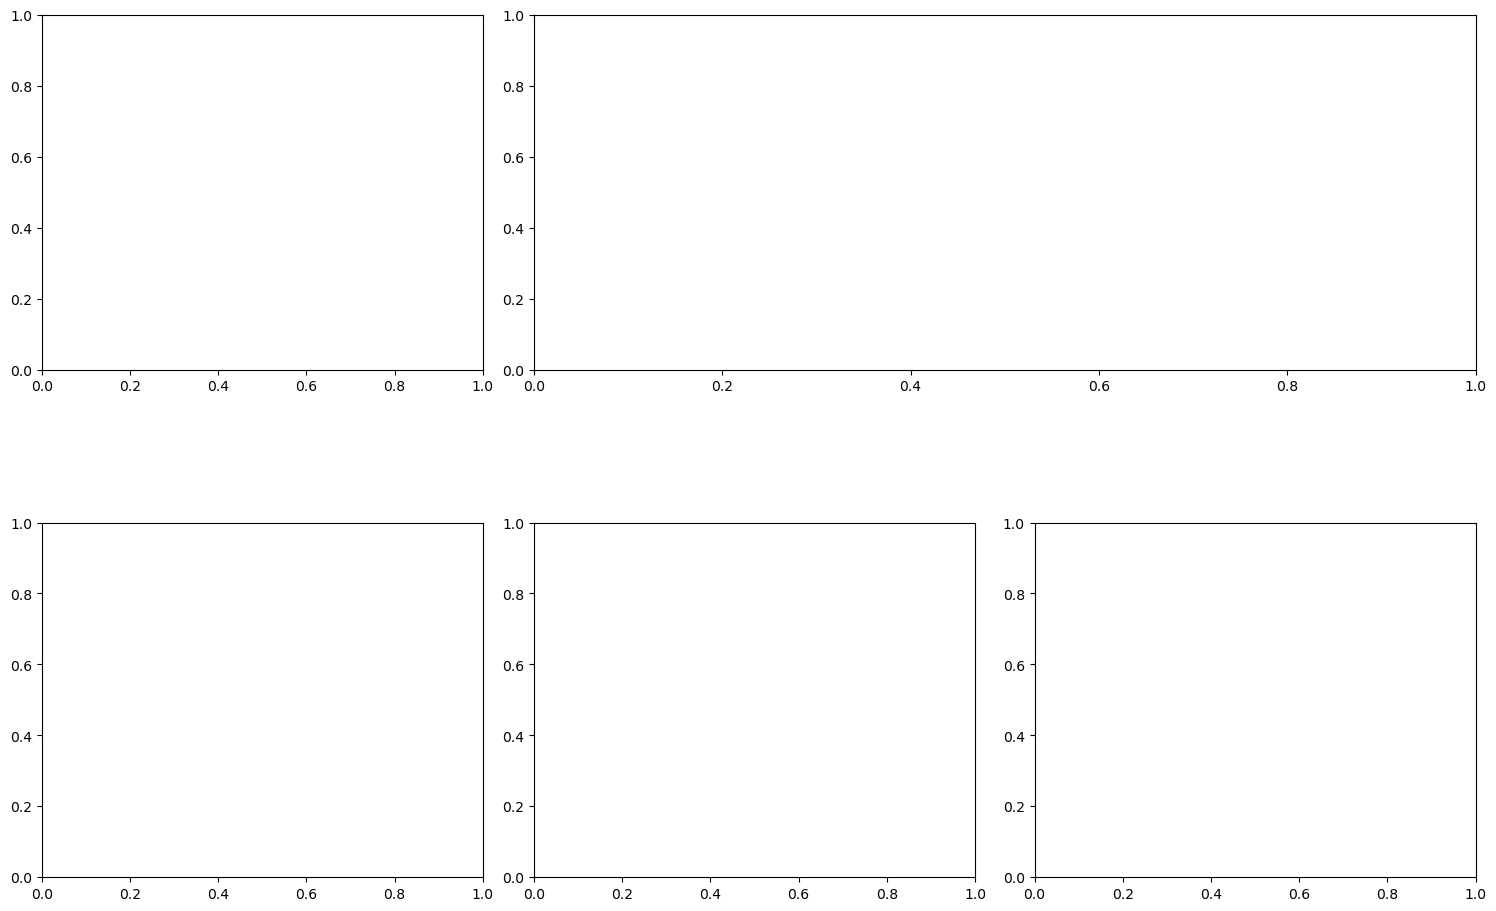

In [24]:
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.95, 0.5, k, transform=ax.transAxes, **kw)

fig = plt.figure(constrained_layout=True, figsize = [9*1.65, 9])
axd = fig.subplot_mosaic( """
    AABBBB
    CCDDEE
    """,gridspec_kw = {"hspace":0.275} 
                        
                        
        )


fontsize = 14 
kw = dict(fontsize=24, color="black", fontweight="bold")
#for k, ax in axd.items():
#     print (ax)
#    if k == 'B':
#        print ('here?')
        #ax.text(0, 0.95, k, transform=ax.transAxes,
        #    fontsize=24, fontweight='bold', va='top')
#    else:
        #ax.text(0.05, 0.95, k, transform=ax.transAxes,
        #    fontsize=24, fontweight='bold', va='top')

In [25]:
active_qualitative_map_mligs = lambda num_ligs: plt.cm.viridis(np.linspace(0,1,num_ligs))
color_blind_frienfly = active_qualitative_map_mligs(5)

In [26]:
# Plot the timeseries:
import pandas as pd
from reeds.function_libs.file_management import file_management as fM

traj_gaff = pd.concat([fM.parse_csv_energy_trajectory(data_dir + f'/complex_gaff/energies_seed_{seed}.dat') for seed in range(1, 6)])
#thresholds = np.genfromtxt(data_dir +'/thres/complex_gaff_thresholds.csv')
#idx_sampled = [np.where(traj_gaff['e'+str(i+1)] < thresholds[i]) for i in range(0, 7)]


traj_off = pd.concat([fM.parse_csv_energy_trajectory(data_dir + f'/complex_openff/energies_seed_{seed}.dat') for seed in range(1, 6)])
#thresholds_off = np.genfromtxt(data_dir +'/thres/complex_openff_thresholds.csv')
#idx_sampled_off = [np.where(traj_off['e'+str(i+1)] < thresholds_off[i]) for i in range(0, 7)]

# Doing it with the maxContrib criterion instead
vis = ['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7']


imd_gaff = Imd(f'{data_dir}/complex_gaff/input.imd')
eoff_gaff = np.array(imd_gaff.REPLICA_EDS.EIR, dtype=float).T[0]

print (eoff_gaff)

traj_gaff2 = copy.deepcopy(traj_gaff)

for state, eoff in zip(vis, eoff_gaff):
    traj_gaff2[state] -= eoff

mins_gaff = np.argmin(np.array(traj_gaff2[vis]), axis=1)
idx_sampled_gaff = [np.where(mins_gaff == i) for i in range(0, 7)]

####

imd_openff = Imd(f'{data_dir}/complex_openff/input.imd')
eoff_openff = np.array(imd_openff.REPLICA_EDS.EIR, dtype=float).T[0]
traj_off2 = copy.deepcopy(traj_off)

for state, eoff in zip(vis, eoff_openff):
    traj_off2[state] -= eoff

mins_off = np.argmin(np.array(traj_off2[vis]), axis=1)
idx_sampled_off = [np.where(mins_off == i) for i in range(0, 7)]


[   0.   -102.11  -25.65   80.69 -251.72   -0.82  125.71]


In [27]:
# 1 Plot free energies

sim = [dgs_sim_openff, dgs_sim_gaff]

labels_sim = ['OpenFF', 'GAFF',]

fontsize = 20

def plot_errorbar(ax, x, y, y_err, color, label, zorder, alpha, marker = 's'):
    markers, caps, bars = ax.errorbar(x, y, y_err, fmt=marker, markersize = 6,
                                      color = color, mec = color,
                                      ecolor = color, label = label,
                                      capthick=1.5, capsize=4, linewidth = 3,
                                      zorder=zorder, alpha = alpha
                                     )
    [bar.set_alpha(1) for bar in bars]
    [cap.set_alpha(1) for cap in caps]

active_qualitative_map_mligs = lambda num_ligs: plt.cm.viridis(np.linspace(0,1,num_ligs))
color_blind_frienfly = active_qualitative_map_mligs(5)

xmin = np.min(dgs_exp)
xmax = np.max(dgs_exp)

plot_errorbar(axd['A'], dgs_exp, dgs_sim_gaff[0], dgs_sim_gaff[1], color = '#bb1177',
              label = labels_sim[1], zorder = 10, alpha = 1, marker = 's')

plot_errorbar(axd['A'], dgs_exp, dgs_sim_openff[0], dgs_sim_openff[1], color = '#3388cc',
              label = labels_sim[0], zorder = 11, alpha = 0.85, marker = 's')

# Make the lines, etc. 

x = np.linspace(-100, 100, 50)

axd['A'].plot(x, x, color = 'black')
axd['A'].plot(x, x-4.185, color = 'lightgrey')
axd['A'].plot(x, x+4.185, color = 'lightgrey')
#
axd['A'].fill_between(x, x-4.185, x+4.185, color='lightgrey')
axd['A'].fill_between(x, x-2*4.185, x+2*4.185, color='lightgrey', alpha=0.5)

axd['A'].set_xlabel(r'$\Delta G_{bind}$ - Experimental [kJ/mol]', fontsize = fontsize)
axd['A'].set_ylabel(r'$\Delta G_{bind}$ - RE-EDS [kJ/mol]', fontsize = fontsize)

axd['A'].set_xticks(np.arange(-55, -25, 5))
axd['A'].set_yticks(np.arange(-55, -25, 5))
axd['A'].tick_params(axis="y",direction="in", length = 6, width = 1.5, labelsize=fontsize)
axd['A'].tick_params(axis="x",direction="in", length = 6, width = 1.5, labelsize=fontsize)

for axis in ['top','bottom','left','right']:
    axd['A'].spines[axis].set_linewidth(1)

axd['A'].set_ylim([-55.5, -29.5]) 
axd['A'].set_xlim([-55.5, -29.5]) 

for axis in ['top','bottom','left','right']:
    axd['A'].spines[axis].set_linewidth(2)

In [28]:
def extract_data(path_csv): 
    vec = np.genfromtxt(path_csv).T    
    # time, dihedrals
    return vec[0]/1000, mod2pi(vec[1:])

def mod2pi(v):
     return np.degrees(np.mod(np.radians(v), 2*np.pi))

duplicates = []
for i in range(1, 51):
    #print (i*250 + i)
    duplicates.append(i*250 + i -1)

# To open a pre-exising csv
time, dihedrals = extract_data(data_dir + '/trajs_s1/dihedrals_complex_gaff_all_seeds.csv')
time_off, dihedrals_off = extract_data(data_dir + '/trajs_s1/dihedrals_complex_openff_all_seeds.csv')


# remove duplicate values...
dihedrals  = np.delete(dihedrals, duplicates, axis=1)
dihedrals_off  = np.delete(dihedrals_off, duplicates, axis=1)

time = np.arange(0, 25, step =0.002)
time_off = np.arange(0, 25, step =0.002)

In [29]:
openff_distances = np.loadtxt(data_dir + '/trajs_s1/distance_l1_lys57_openff.csv')
gaff_distances = np.loadtxt(data_dir + '/trajs_s1/distance_l1_lys57_gaff.csv')

duplicates = []
for i in range(1, 51):
    #print (i*250 + i)
    duplicates.append(i*250 + i -1)

openff_distances  = np.delete(openff_distances.T, duplicates, axis=1)
gaff_distances = np.delete(gaff_distances.T, duplicates, axis=1)

In [30]:
axd['C'].cla()
axd['D'].cla()
axd['E'].cla()

In [31]:
state = 0

other_color = 'silver'
s = 0.15
alpha = 0.5
marker = 'D'

c = color_blind_frienfly

axd['C'].scatter(time, mod2pi(dihedrals[state]), s = s,  color = other_color, alpha = alpha)


axd['C'].scatter(time[idx_sampled_gaff[state]], 
                 mod2pi(dihedrals[state][idx_sampled_gaff[state]]), 
                 s = 8, color = '#bb1177', edgecolors = '#bb1177', linewidth = 0.25, marker = marker, zorder = 5) 


axd['C'].set_ylim([0, 360])

# 

# 

axd['D'].scatter(time, mod2pi(dihedrals_off[state]), s = s,  color =other_color, alpha = alpha) 
axd['D'].scatter(time[idx_sampled_off[state]], 
                 mod2pi(dihedrals_off[state][idx_sampled_off[state]]), 
                 s = 8, color ='#3388cc', edgecolors = '#3388cc', linewidth = 0.25, marker = marker, zorder = 5) 

# 

#axd['D'].scatter(time, mod2pi(dihedrals_rest[state]), s = s,  color = other_color, alpha = alpha) 
#axd['D'].scatter(time[idx_sampled_rest[state]], 
#                 mod2pi(dihedrals_rest[state][idx_sampled_rest[state]]), 
#                 s = 8, color ='#dd99bb', edgecolors = '#dd99bb', linewidth = 0.25, marker = marker, zorder = 5) 


axd['D'].set_ylim([0, 360])



axd['C'].set_yticks([0, 60, 120, 180, 240, 300, 360])
axd['D'].set_xlabel('time [ns]', fontsize = fontsize) 
axd['C'].set_xlabel('time [ns]', fontsize = fontsize) 
axd['C'].set_ylabel('Dihedral angle [deg.]', fontsize = fontsize)


for i in ['C', 'D',]:
    axd[i].set_ylim([0, 360])
    axd[i].set_xlim([0, 25])
    axd['C'].set_xticks([0, 5, 10, 15, 20, 25])
    
    axd[i].set_zorder(99)
    
    if i != 'C':
        axd[i].get_yaxis().set_visible(False)

        
axd['E'].hist(openff_distances[1][idx_sampled_off[state]], density=True, 
              bins = 50, histtype='step', edgecolor ='#3388cc', range=[0.15, 0.9], lw=2)


axd['E'].hist(gaff_distances[1][idx_sampled_gaff[state]], density=True, bins = 50, histtype='step', edgecolor ='#bb1177', range=[0.15, 0.9], lw=2)


axd['E'].axvspan(0.25, 0.35, alpha=0.5, color='lightgrey')

axd['E'].set_xlabel('Distance Lys299 - carbonyl [nm]', fontsize = fontsize) 

axd['E'].yaxis.tick_right()
axd['E'].set_ylabel('Density', fontsize = fontsize, labelpad=0,)
axd['E'].set_xticks([0.25, 0.5, 0.75])
# axd['E'].set_yticks([100, 200, 300, 400, 500, 600])   



for i in ['C', 'D', 'E']:
    axd[i].tick_params(axis="y",direction="in", length = 6, width = 1, labelsize=fontsize, )
    axd[i].tick_params(axis="x",direction="in", length = 6, width = 1, labelsize=fontsize, )

for i in ['C', 'D', 'E']:
    for axis in ['top','bottom','left','right']:
        axd[i].spines[axis].set_linewidth(2)
    axd[i].xaxis.set_tick_params(width = 2)
    axd[i].yaxis.set_tick_params(width = 2)
    

# adding 3 points outside bounds for legend:

s = 64

axd['D'].scatter(-1000, -1000, color = '#bb1177', label = 'GAFF', marker = 's', s= s)
# axd['D'].scatter(-1000, -1000, color = '#dd99bb', label = 'GAFF (restrained)', marker = 's', s= s)
axd['D'].scatter(-1000, -1000, color = '#3388cc', label = 'OpenFF', marker = 's', s =s)

leg = axd['D'].legend(loc = 'upper center', fontsize=24, fancybox=True, 
                      ncol = 2, bbox_to_anchor=(0.5, 1.25))

leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.5)
leg.get_frame().set_zorder(100)
    

    
    

In [32]:
for i in ['A']:
    axd[i].set_aspect('equal', 'box')

In [33]:
#im = plt.imread(('//fileserver/pine/pine2/cchampion/REEDS/1_genentech_project/paper_programs/notebooks/data_for_plots/pak/white.png'))

#axd['B'].imshow(im)

#axd['B'].get_yaxis().set_visible(False)
#axd['B'].get_xaxis().set_visible(False)

#for axis in ['top','bottom','left','right']:
#    axd['B'].spines[axis].set_visible(False)

In [ ]:
fig

In [ ]:
# fig.savefig('/home/cchampion/Desktop/PAK_new.png', facecolor='white', dpi=300)

In [ ]:
fig

# Other way to look at it 

In [ ]:
"""
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =[4, 6])

state = 0

ax.hist( mod2pi(dihedrals_off[state][idx_sampled_off[state]]), bins=36, alpha = 1, color = 'white', edgecolor ='#3388cc', histtype = 'step')

ax2 = ax.twinx()

ax2.hist( mod2pi(dihedrals[state][idx_sampled_gaff[state]]), bins=36, color = 'white', edgecolor ='#bb1177',  histtype = 'step')

ax.set_xlabel('dihedral angle', fontsize = 18)

ax.set_ylabel('count', fontsize = 18)
ax2.set_ylabel('count', fontsize = 18)
"""

# Looking at distances rather than torsions

In [ ]:
openff_distances = np.loadtxt(data_dir + '/trajs_s1/distance_l1_lys57_openff.csv')
gaff_distances = np.loadtxt(data_dir + '/trajs_s1/distance_l1_lys57_gaff.csv')

duplicates = []
for i in range(1, 51):
    #print (i*250 + i)
    duplicates.append(i*250 + i -1)


openff_distances  = np.delete(openff_distances.T, duplicates, axis=1)
gaff_distances = np.delete(gaff_distances.T, duplicates, axis=1)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =[6, 4])

ax.hist(openff_distances[1][idx_sampled_off[state]], density=True,
        bins = 100, histtype='step', edgecolor ='#3388cc', range=[0.15, 0.9])
# ax2 = ax.twinx()
ax.hist(gaff_distances[1][idx_sampled_gaff[state]], density=True,
         bins = 100, histtype='step', edgecolor ='#bb1177', range=[0.15, 0.9])

ax.axvspan(0.25, 0.35, alpha=0.5, color='lightgrey')



In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =[6, 4])


ax.hist(openff_distances[1][idx_sampled_off[state]], bins = 50, histtype='step', edgecolor ='#3388cc', range=[0.15, 0.9], lw=2)

ax.axvspan(0.25, 0.35, alpha=0.5, color='lightgrey')

# axd['E'].set_xlabel('Distance Lys299 - carbonyl [nm]', fontsize = fontsize) 

#axd['E'].yaxis.tick_right()

#axd['E'].set_ylabel('Count', fontsize = fontsize, labelpad=1,)

ax.tick_params(axis="y",direction="in", length = 6, width = 1, labelsize=fontsize, )
ax.tick_params(axis="x",direction="in", length = 6, width = 1, labelsize=fontsize)
ax.set_xticks([0.25, 0.5, 0.75])
# axd['E'].set_yticks([100, 200, 300, 400, 500, 600])   




ax2 = ax.twinx()
ax2.hist(gaff_distances[1][idx_sampled_gaff[state]], bins = 50, histtype='step', 
           edgecolor ='#bb1177', range=[0.15, 0.9], lw= 2)

ax2.tick_params(axis="y",direction="in", length = 6, width = 1, labelsize=fontsize, )


# Note: I added the subfigure B back in powerpoint 

In [242]:
# fig.savefig('/cluster/home/cchampion/work/REEDS/pak/PAK_results_fig2.pdf', dpi=300, facecolor='white')
# fig.savefig('//home/cchampion/tmp/PAK_results_fig_new2.png', dpi=300, facecolor='white', bbox_inches='tight')